# The Ferguson Fire in 2018

### The Ferguson Fire was a major wildfire in the Sierra National Forest, Stanislaus National Forest and Yosemite National Park in California in the United States.
#### The fire, which burned mostly in inaccessible wildland areas of the national forest, impacted recreational activities in the area, including in Yosemite National Park, where Yosemite Valley and Wawona were closed [(NIFC, Wikipedia)](https://en.wikipedia.org/wiki/Ferguson_Fire#:~:text=Throughout%20the%20first%20half%20of,detected%20within%20the%20containment%20lines.).

Half Dome and Yosemite Valley in heavy smoke, August 5, 2018
![Half Dome and Yosemite Valley in heavy smoke, August 5](https://upload.wikimedia.org/wikipedia/commons/d/d7/2018_08_05-23.34.19.164-CDT.jpg)
> Image source: [US Forest Service, Public domain, via Wikimedia Commons](https://commons.wikimedia.org/wiki/File:2018_08_05-23.34.19.164-CDT.jpg)

In [123]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [124]:
# Generating the path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), "earth-analytics", "data", "camp-fire")

# Create the project directory
os.makedirs(project_dir, exist_ok=True)

In [125]:
# Download fire perimeter about Camp Fire
camp_gdf = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/"
    "Historic_Geomac_Perimeters_2018/FeatureServer/0/query"
    "?where=incidentname%20%3D%20'FERGUSON'"
    "%20AND%20latest%20%3D%20'Y'"
    "&outFields=*&outSR=4326&f=json")

In [126]:
# Arch Rock Entrance, CA location 
# From GoogleMaps
arch_lat = 37.686017
arch_lon = -119.730904

# Create a Folium map object
m = folium.Map(
    location=[arch_lat,arch_lon], 
    zoom_start= 10.45,
    scrollWheelZoom=False,
    )

# Add ESRI World Imagery as the baselayer
folium.TileLayer(
    tiles=
    'http://server.arcgisonline.com/ArcGIS/rest/services/'
    'World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri World Imagery',
    overlay=False,
).add_to(m)

# Convert the GeoDataFrame to GeoJSON format
camp_geojson = camp_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
camp_style = {
    "fillColor": "red",
    "color": "black",
    "weight": 2,
    "dashArray": "5, 5",
}

folium.GeoJson(
    camp_geojson, 
    style_function=lambda feature: camp_style
    ).add_to(m)

# Add marker
folium.Marker(
    location=[arch_lat,arch_lon],
    tooltip="Arch Rock Entrance Yosemite National Park, CA"
    ).add_to(m)

# Display the map
m

#### The fire perimeter contained parts of the Yosemite National Park forcing closures in the Yosemite Valley.

In [127]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key='modis-ndvi',
    ea_dir=project_dir,
    product='MYD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date='06-01',
    end_date='08-31',
    recurring=True,
    year_range=[2017, 2022],
    polygon=camp_gdf
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

In [128]:
# Find path to only files that contain NDVI data
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))

In [129]:
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

In [130]:
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])

<function matplotlib.pyplot.show(close=None, block=None)>

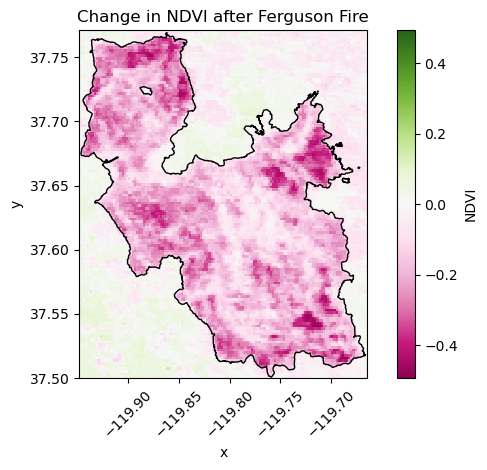

In [131]:
import matplotlib.pyplot as plt

#Calculate the change in NDVI pre- and post-fire
dndvi_da = (ndvi_ds
    .sel(date='2019')
    .mean('date')
    .NDVI
 - ndvi_ds
    .sel(date='2017')
    .mean('date')
    .NDVI
)    

dndvi_da.plot(cmap=plt.colormaps['PiYG'])
camp_gdf.plot(facecolor='none', ax=plt.gca())
plt.title("Change in NDVI after Ferguson Fire")

# Customize the x-axis labels
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees

# Adjust the spacing between x-axis labels
plt.tight_layout()

plt.show

## Did the NDVI drop more inside the fire boundary than nearby?

In [132]:
# Get the area outside the fire boundary
out_gdf = (
    gpd.GeoDataFrame(geometry=camp_gdf.envelope)
    .overlay(camp_gdf, how="difference")
)

In [133]:
# Clip data to inside and outside fire boundary
ndvi_fire_ds = ndvi_ds.rio.clip(camp_gdf.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [134]:
ndvi_fire_df = (
    ndvi_fire_ds
    .groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])
ndvi_out_df = (
    ndvi_out_ds
    .groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])

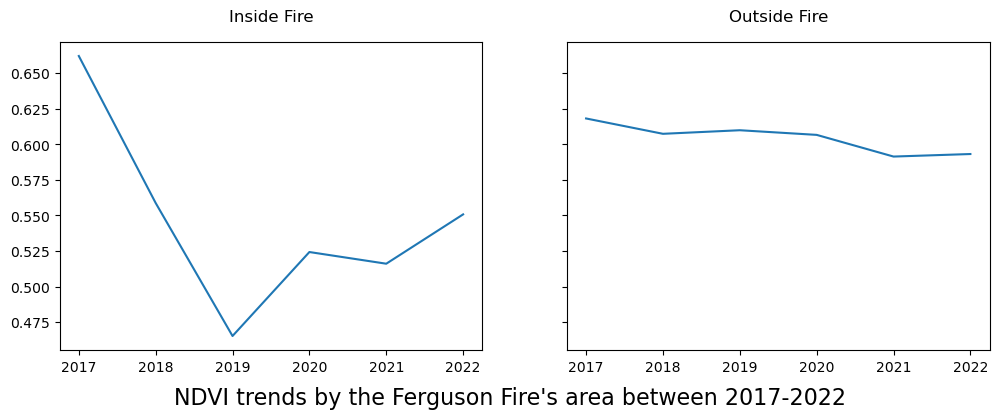

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

ax1.plot(ndvi_fire_df)
ax1.set_title("Inside Fire", pad=15)

ax2.plot(ndvi_out_df)
ax2.set_title("Outside Fire", pad=15)

plt.suptitle(
    "NDVI trends by the Ferguson Fire's area between 2017-2022",
    fontsize=16,
    y=0.02)

plt.show()

### The NDVI values show a slight descrease between 2017 and 2022 even outside the fire perimeter, but the inside fire values exhibit an extreme decrease as a result of Ferguson Fire. 

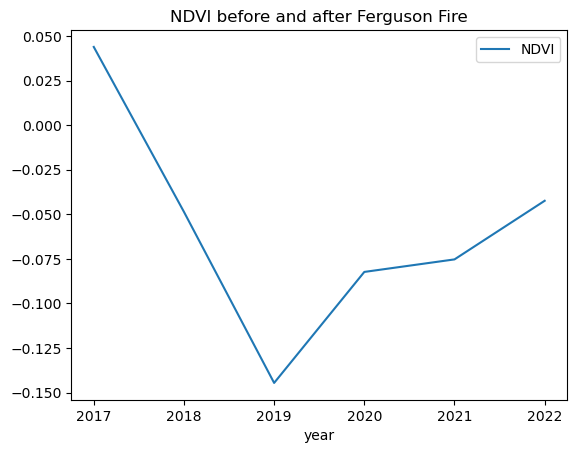

In [136]:
(ndvi_fire_df - ndvi_out_df).plot()
plt.title("NDVI before and after Ferguson Fire")

plt.show()

## The NDVI dropped significantly after the fire and the area's NDVI values still not recovered to the pre-fire level years after the incident. 

In [121]:
%%capture
%%bash
jupyter nbconvert modis-ndvi.ipynb --to html --no-input